# SkyrimFaceFinder
Simple Neural Network Identifier for Skyrim Vanilla Pregens.

### Business Understanding
Skyrim recently had a re-release, and has a slider-based character build system.  Sometimes you want to make a character that looks like someone, i.e. you want to make yourself, a celebrity, a specific piece of art, etc.  The goal of this project is to use tensorflow to create a Neural Network that will find the closest pregen character to a given photograph/picture.

**Constraints**
In order to limit this project (and allow a quick 'win' for me), I will make the following limitations.  If you want to borrow this code to go beyond that, please do.
* *Human Only* - This will be so that the author can find the closest pregen to their own face.
* *Specific pose* - This allows a regular neural net (with creepy eigenfaces) and avoids the need for a CNN, which I'd doing plenty of over in my [Dog Classifier](https://github.com/NeverForged/DogClassifier), which at the time of this writing is still a WIP.

### Data Understanding
Since my laptop cannot run graphics-intensive games, and my only game system is an xbox 360, I will stick to the standard pregens.  This is good, since it limits the data.  I found a decent source of picture [here](https://levelskip.com/rpgs/skyrimthebestrace).  This of course means I will need to play around with these images.

These give me literally 1 image for each pregen.  I will need to manipulate these to make multiple versions of each of these pictures, likely by scalling up or down by a pixel

### Data Preparation
Again, stealing a bit from my [Dog Classifier](https://github.com/NeverForged/DogClassifier), I can build a little python code that will manipulate these images.
Mostly just offsetting them by 1-2 pixels in each direction, which also resizes them to make them 100 x 100.

In [1]:
## change this to limit to a single phenotype, male or female.  anything else for both
limit = 'none of that filtering here'

In [2]:
from image_maker import SkyrimImages



images = SkyrimImages(limit=limit)
images.generate_img_files()
train_imgs = images.load_images('train')
test_imgs = images.load_images('test')
Xtest = test_imgs[0]
Ytest = test_imgs[1]
Xtrain = train_imgs[0]
Ytrain = train_imgs[1]
print()
print(len(images.racenames))

../Data
Redguard9
80


In [3]:
import numpy as np
Xhold = Xtrain.copy()
Yhold = Ytrain.copy()
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtrain[i, :] = Xhold[n, :]
    Ytrain[i, :] = Yhold[n, :]
    
Xhold = Xtest
Yhold = Ytest
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtest[i, :] = Xhold[n, :]
    Ytest[i, :] = Yhold[n, :]

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

picsize = 100  # defined in a file

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 100*100*3], name='X')

# When passing through the network, we want to represent the images
# as a 4-tensor: (n_images, image_height, image_width, n_channels)
x_image = tf.reshape(x, [-1, 100, 100, 3], name='ximage')

**What It Looks Like**

(2092, 100, 100, 3)


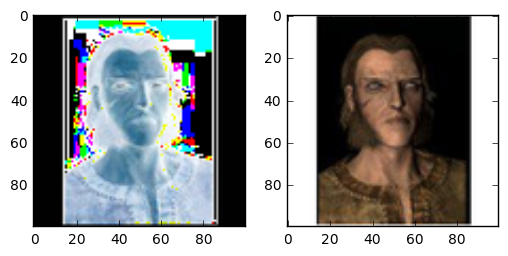

In [6]:
sess = tf.InteractiveSession()
# with tf.Session() as sess:
# Initialize everything and prepare for training.
sess.run(tf.global_variables_initializer())
print(x_image.eval(feed_dict={x:Xtrain}).shape)
img = x_image[0].eval(feed_dict={x:Xtrain})
fig, axes = plt.subplots(1, 2)
ax=list(axes.flatten())
ax[0].imshow(img)
ax[0].grid(False)
ax[1].imshow(Image.fromarray(np.uint8(img)))
ax[1].grid(False)
plt.show()

In [7]:
lst_races  = images.racenames

def shuffle_function(X, y):
    Xhold = X.copy()
    Yhold = y.copy()
    new = np.array([i for i in range(Xhold.shape[0])])
    np.random.shuffle(new)
    for i, n in enumerate(new):
        X[i, :] = Xhold[n, :]
        y[i, :] = Yhold[n, :]
    return X, y

### Modeling
![Network](https://github.com/NeverForged/DogClassifier/blob/master/Source/WebImages/fully_connected.png)
The network above should do the job.

In [8]:
# Placeholder for the input data.
x = tf.placeholder(tf.float32, [None, picsize * picsize*3])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, len(lst_races)])

# Weights.  There are len(lst_dogs) output classes, and one weight per (pixel, output class)
# combination.
W = tf.Variable(tf.truncated_normal([picsize * picsize * 3, len(lst_races)], stddev=0.1), name='W')

# Biasies.  This is like an intercept term in a linear regression.  There is one
# per output class.
b = tf.Variable(tf.truncated_normal([len(lst_races)], stddev=0.1), name='b')

# Output layer
y_hat = tf.matmul(x, W) + b


In [9]:
#Training & Loss Function

# The basic loss function, cross entropy.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))

# Use L2 regularization

regularization_term = 0.5 * (
    tf.nn.l2_loss(W))

# The total loss function we will minimize is cross entropy
# plus regularization.
total_loss = cross_entropy + regularization_term

correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train the model by gradient descent, for a fixed 1000 iterations.
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(total_loss)
tf.global_variables_initializer().run()

In [10]:
acc = -1
save_acc = -1
slides = 200
train_steps = int(Xtrain.shape[0]/slides)
for ep in range(100):
    Xtrain, Ytrain = shuffle_function(Xtrain, Ytrain)
    for i in range(train_steps):
        if i*slides + slides - 1 <= Xtrain.shape[0]:
            batch_xs = Xtrain[i*slides:i*slides + slides - 1] 
            batch_ys = Ytrain[i*slides:i*slides + slides - 1]
            sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
            myloss = total_loss.eval( feed_dict={x: batch_xs, y: batch_ys})
            print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}% - Loss {:.4f}'.format(100*(ep+1)/100, 
                                                                   acc,
                                                                   myloss), end='')
    acc = accuracy.eval(feed_dict={x: Xtest, y: Ytest})*100
    if acc >= save_acc:
        save_acc = acc
        save_W = W.eval()
        save_b = b.eval()
    print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}% - Loss {:.4f}'.format(100*(ep+1)/100, 
                                                                   acc,
                                                                   myloss), end='')
print()

W1 = tf.get_variable('W1', initializer=tf.constant(save_W))
b1 = tf.get_variable('b1', initializer=tf.constant(save_b))
y1_hat = tf.matmul(x, W1) + b1
correct_prediction1 = tf.equal(tf.argmax(y1_hat, 1), tf.argmax(y, 1))
pred = tf.argmax(y1_hat, 1)
accuracy1 = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("Test Error Accuracy: {:0.2f}%".format(100*sess.run(accuracy1, feed_dict={x: Xtest, y: Ytest})))

 Percent Complete: 100.00% - Accuracy 100.00% - Loss 2142.6328
Test Error Accuracy: 100.00%


Let's see some eigenfaces...

In [11]:
from math import sqrt

def plot_digit_weights(ax, image, convert=False): 
    """Plot the weights from our fit fully connected network as an image."""
    size = image.shape[0]
    n = int(sqrt(size/3))
    img = image.reshape(n,n,3)
#     if convert==True:
#         img = Image.fromarray(np.uint8(img))
    ax.imshow(img)

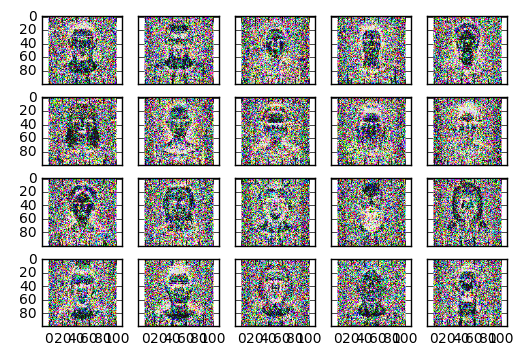

In [12]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True)
for n, ax in enumerate(axs.flatten()):
        plot_digit_weights(ax, save_W[:,n])

plt.show()

### Evaluation
Showing how well it did on my face.

In [13]:
import os

inputs = [a for a in os.listdir('../Input')]
#.convert('RGB')
ximages = np.zeros((len(inputs), 100*100*3))
for i, imagename in enumerate(inputs):
    ximages[i,:] = np.array(Image.open('../Input/'+imagename).convert('RGB')).reshape((-1,))

In [14]:
tf.global_variables_initializer().run()
ans = pred.eval(feed_dict={x:ximages, y:Ytest})

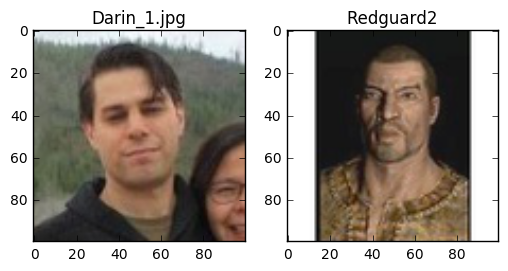

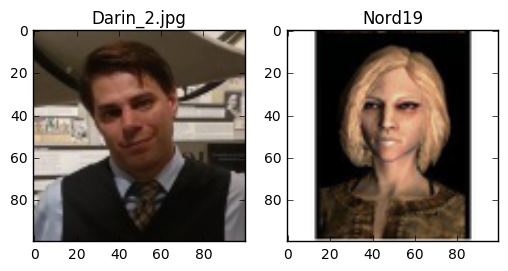

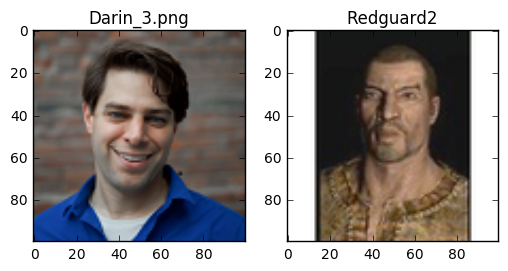

In [15]:
for i, an in enumerate(list(ans)):
    fig, axes = plt.subplots(1, 2)
    ax=list(axes.flatten())
    ax[0].imshow(Image.open('../Input/'+inputs[i]).convert('RGB'))
    ax[0].grid(False)
    ax[0].set_title(inputs[i])
    imgs = [a for a in os.listdir('../Data/'+lst_races[an]+'/train')]
    img = Image.open('../Data/'+lst_races[an]+'/train/'+imgs[0]).convert('RGB')
    ax[1].set_title(lst_races[an])
    ax[1].imshow(Image.fromarray(np.uint8(img)))
    ax[1].grid(False)
    plt.show()